Check running TensorFlow version

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

# Sentiment movie reviews classification

This is a binary classification problem (2 classes, negative and positive). 

The dataset I will use is [IMDB reviews](https://ai.stanford.edu/~amaas/data/sentiment/), it contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.

I will use a basic dense model to start with and find out how well it performs on this dataset. 1D conv, LSTM, GRU, Bidirectional are stuff I can try later.

In [2]:
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import matplotlib.pyplot as plt
%matplotlib inline

import random as rand

import numpy as np

import shutil

In [3]:
batch_size = 256

## Load IMDB review and get familiar with it

In [4]:
vocab_size = 10000
(train_x, train_y), (test_x, test_y) = datasets.imdb.load_data(num_words=vocab_size)

In [5]:
train_x.shape, train_y.shape

((25000,), (25000,))

In [6]:
test_x.shape, test_y.shape

((25000,), (25000,))

Load the word index dictionary and reverse a few triaing strings

Note: the indices are offset by 3 because 0, 1, and 2 are reserved indices for "padding", "start of sequence", and "unknown".

In [7]:
word_index = datasets.imdb.get_word_index()
word_index = {key: (value + 3) for key, value in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

word_index_reversed = {value: key for key, value in word_index.items()}

In [8]:
translate_sentence = lambda sentence : " ".join([word_index_reversed.get(word, '?') for word in sentence])

In [9]:
random_indecies = rand.choices(list(range(train_x.shape[0])), k=1)

for index in random_indecies:
    sentence = translate_sentence(train_x[index][1:])
    print(sentence, end="\n\n")

daniel day lewis is the most versatile actor alive english <UNK> <UNK> in a room with a view passionate irish thief in in the name of the father an <UNK> violent butcher in gangs of new york in a performance ten times stronger than adrian <UNK> in the <UNK> and as the outrageous <UNK> brown with cerebral <UNK> in my left foot just to name a few his roles all influence <UNK> but each is <UNK> and utterly unique he changes completely with each character he takes on and i'm beginning to believe that he can act as anything anything br br as <UNK> brown he is stunning he does not <UNK> the character and he does not pity the character a difficult achievement and <UNK> brown comes to life a smart man an outrageous man human br br this movie despite small scene transition faults and the like is an inspiration yes it's predictable but is it <UNK> sentimental no i laughed i cried not a single moment of cheese proof that this isn't a hollywood movie br br my favourite scene is the scene in the re

## Pad the training and test data

Because of input data is of different sizes, I will set a max length limit on them or pad them if their length was shorter than max length

In [10]:
max_length = 200

# Default :: , padding='pre', truncating='pre'
train_x = pad_sequences(train_x, maxlen=max_length)
test_x = pad_sequences(test_x, maxlen=max_length)

In [11]:
train_x.shape, test_x.shape

((25000, 200), (25000, 200))

## Train

In [34]:
embedding_size = 32

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_size, input_length=max_length))

model.add(layers.LSTM(16))

# Option 2: Helped with overfitting but final was less performant
# model.add(layers.LSTM(16, recurrent_dropout=.5))

# Option 3: Worked a little better but not worth it
# model.add(layers.Bidirectional layers.LSTM(16))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 323,153
Trainable params: 323,153
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
history = model.fit(x=train_x, y=train_y, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=10)
history.history.keys()

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 11s 557us/sample - loss: 0.5818 - accuracy: 0.7227 - val_loss: 0.4395 - val_accuracy: 0.8344
Epoch 2/10
20000/20000 [==============================] - 10s 479us/sample - loss: 0.3680 - accuracy: 0.8592 - val_loss: 0.3640 - val_accuracy: 0.8476
Epoch 3/10
20000/20000 [==============================] - 10s 477us/sample - loss: 0.2723 - accuracy: 0.8964 - val_loss: 0.3125 - val_accuracy: 0.8690
Epoch 4/10
20000/20000 [==============================] - 10s 476us/sample - loss: 0.2263 - accuracy: 0.9167 - val_loss: 0.3083 - val_accuracy: 0.8700
Epoch 5/10
20000/20000 [==============================] - 10s 477us/sample - loss: 0.1893 - accuracy: 0.9317 - val_loss: 0.4454 - val_accuracy: 0.8430
Epoch 6/10
20000/20000 [==============================] - 9s 470us/sample - loss: 0.1685 - accuracy: 0.9398 - val_loss: 0.3114 - val_accuracy: 0.8806
Epoch 7/10
20000/20000 [======================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

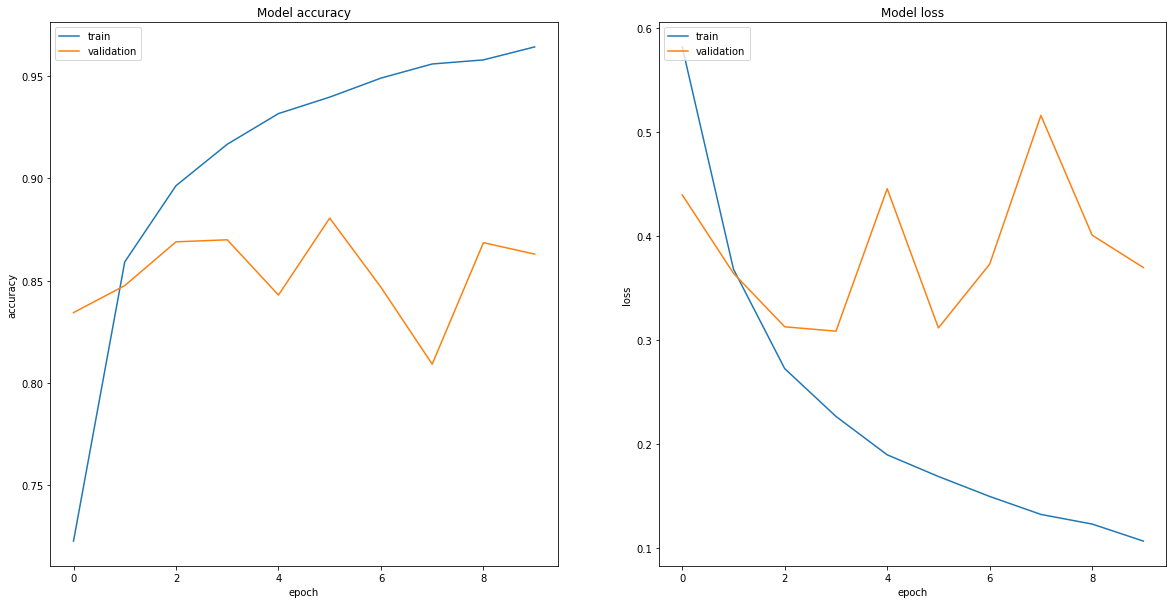

In [37]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Evaluate

In [39]:
loss, accuracy = model.evaluate(x=test_x, y=test_y)
loss, accuracy

25000/25000 [==============================] - 23s 917us/sample - loss: 0.4133 - accuracy: 0.8448


(0.4133335279750824, 0.84476)

## Predict on one sentence

In [40]:
model.trainable = False

# Compile model so changes to trainable would take effect
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
sentence

"daniel day lewis is the most versatile actor alive english <UNK> <UNK> in a room with a view passionate irish thief in in the name of the father an <UNK> violent butcher in gangs of new york in a performance ten times stronger than adrian <UNK> in the <UNK> and as the outrageous <UNK> brown with cerebral <UNK> in my left foot just to name a few his roles all influence <UNK> but each is <UNK> and utterly unique he changes completely with each character he takes on and i'm beginning to believe that he can act as anything anything br br as <UNK> brown he is stunning he does not <UNK> the character and he does not pity the character a difficult achievement and <UNK> brown comes to life a smart man an outrageous man human br br this movie despite small scene transition faults and the like is an inspiration yes it's predictable but is it <UNK> sentimental no i laughed i cried not a single moment of cheese proof that this isn't a hollywood movie br br my favourite scene is the scene in the r

In [42]:
index = 0

sentence = test_x[index]
translate_sentence(sentence), test_y[index]

("<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on

In [43]:
sentence = sentence.reshape(1, *sentence.shape)
sentence.shape

(1, 200)

In [44]:
output = model(sentence)
float(output)

0.04726536571979523